# 0. Libraries

In [111]:
# Pandas tools
import pandas as pd
import pandas as pd
import pandas.io.sql as sqlio
from pandas import DataFrame

# Database-related tools
import duckdb
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
from sqlalchemy import create_engine, text, inspect
from sqlalchemy.orm import sessionmaker

# Other utilities
import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Connection to the databases (including the data warehouse) and the .csv

## a. External data sources

Connection or extraction to the provided data sources. 

In [112]:
# Connection to the AIMS and AMOS databases
if 'aims' in globals():
  aims.close()
aims = psycopg2.connect(database='aims', user='bse_airlines', host='dtim.essi.upc.edu', password='BSE2024!', options='-c search_path=bda-aims')
cursor_aims = aims.cursor()
if 'amos' in globals():
  amos.close()
amos = psycopg2.connect(database='amos', user='bse_airlines', host='dtim.essi.upc.edu', password='BSE2024!', options='-c search_path=bda-amos')
cursor_amos = amos.cursor()

Creation of the data warehouse (ROLAP) using the SQL scripts in the `tables_dw` folder. Note that the code below creates a new database for the specified user. UML of the data warehouse (as a reference):

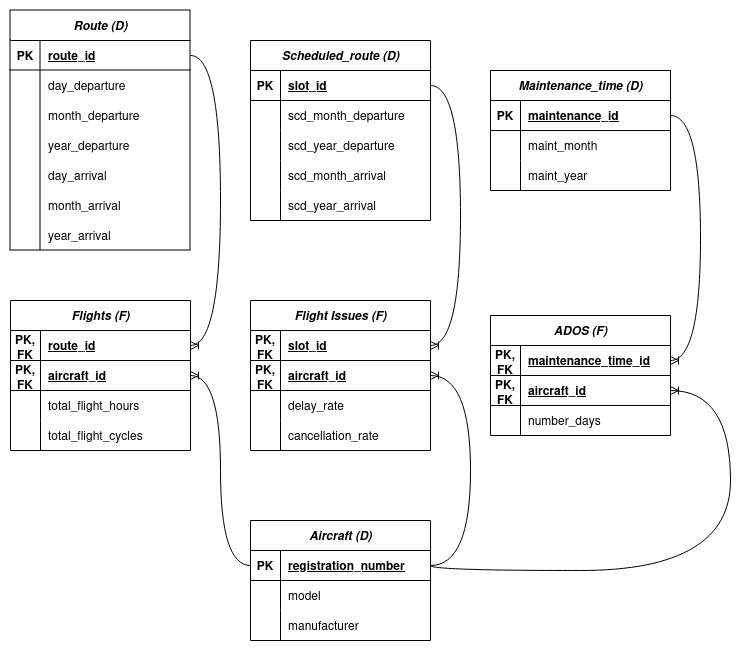

Functions to create the database and the tables of the data warehouse:

# 2. ETL process

## 2.1. Extracting the necessary data from AIMS, AMOS and the aircraft manufacturer lookup (.csv)

For answering the user analytical requirements *R1* and *R2* and filling the data warehouse with meaningful data, we have found it relevant to extract the following data from the data inputs:
- First, the actual times of departure and arrival of the flights (*actualDeparture* and *actualArrival*, from the relation *Flights* of the database AIMS). We will use these timestamps to extract the day, month and year of a certain flight. In turn, this information will then be used for knowing the total flight hours and cycles per aircraft, day, month and year. Only values previous to the current date should be included, and we will check that there were no flights that happened at the same time as maintenance events (which would be inconsistent).
- Second, the *aircraftRegistration* number from the *Flights* relation of the database AIMS, as the flightID is created such that it includes the registration number: `flightID CHAR(26) NOT NULL, -- Date-Origin-Destination-FlightNumber-AircraftRegistration -> 6+1+3+1+3+1+4+1+6` (taken from the SQL file of the creation of AIMS). However, we will check for consistency between this number and the registration number appearing in the relation *Slots* of the database AIMS (as *aircraftRegistration*).
- Third, from the csv we will extract the model and manufacturer for each registration number.
- Fourth, for the requirement R2, we will extract the scheduled time for a flight, which is in the relation *Slots* in the database AIMS (but since *Flights* inherits from *Slots*, *Flights* will suffice for the facts "delay rate" and "cancellation rate").
- Fifth, we will use the boolean *cancelled* and the *delayCode* ("IATA code" of the delay) for computing the rates of flights that have been either delayed or cancelled (including flights that are scheduled for the future). Basically, null delay codes are flights which have operated on schedule, while those with a non-null delay codes have been delayed ([general reference of IATA delay codes](https://en.wikipedia.org/wiki/IATA_delay_codes), [list of codes](https://ansperformance.eu/library/iata-delay-codes.pdf)).
- Sixth, the times of maintenance events (the start time and the duration), which will be used to know the days an aircraft was out of service.

### a. AIMS

In [113]:
# Extract fields of interest from the Flights table, which inherits from Slots - AIMS

Q_flights = "SELECT aircraftregistration, flightid, scheduleddeparture, scheduledarrival, actualdeparture, actualarrival, cancelled, delaycode FROM Flights;"

df_flights = sqlio.read_sql_query(Q_flights, aims)

df_flights.head(10)

,aircraftregistration,flightid,scheduleddeparture,scheduledarrival,actualdeparture,actualarrival,cancelled,delaycode
0,XY-RJL,230803-NRN-JMK-9129-XY-RJL,2023-08-03 11:03:03.875940,2023-08-03 14:03:03.875940,NaT,NaT,True,None
1,XY-OZE,230726-HAU-SAW-9867-XY-OZE,2023-07-26 14:50:15.569812,2023-07-26 15:50:15.569812,NaT,NaT,True,None
2,XY-SJZ,231120-HER-VAA-6975-XY-SJZ,2023-11-20 09:01:04.308766,2023-11-20 13:01:04.308766,NaT,NaT,True,None
3,XY-OXK,230613-VNO-EGC-9468-XY-OXK,2023-06-13 09:55:02.480695,2023-06-13 11:55:02.480695,NaT,NaT,True,None
4,XY-DGU,230312-BLL-BVA-9815-XY-DGU,2023-03-12 00:41:45.198279,2023-03-12 03:41:45.198279,NaT,NaT,True,None
5,XY-CMS,230927-vKo-lUg-5629-XY-CMS,2023-09-27 04:16:33.946201,2023-09-27 05:16:33.946201,NaT,NaT,True,None
6,XY-RJM,230106-ESB-SXF-1266-XY-RJM,2023-01-06 21:23:48.860304,2023-01-07 02:23:48.860304,NaT,NaT,True,None
7,XY-LKU,230730-BHX-BDS-3846-XY-LKU,2023-07-30 13:40:52.793055,2023-07-30 18:40:52.793055,NaT,NaT,True,None
8,XY-CRS,230103-GVA-GDN-4559-XY-CRS,2023-01-03 03:52:12.278595,2023-01-03 04:52:12.278595,NaT,NaT,True,None
9,XY-IVJ,230125-Gva-led-1268-XY-IVJ,2023-01-25 16:50:39.680743,2023-01-25 18:50:39.680743,NaT,NaT,True,None


In [114]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151833 entries, 0 to 151832
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   aircraftregistration  151833 non-null  object        
 1   flightid              151833 non-null  object        
 2   scheduleddeparture    151833 non-null  datetime64[ns]
 3   scheduledarrival      151833 non-null  datetime64[ns]
 4   actualdeparture       141792 non-null  datetime64[ns]
 5   actualarrival         141792 non-null  datetime64[ns]
 6   cancelled             151833 non-null  bool          
 7   delaycode             14166 non-null   object        
dtypes: bool(1), datetime64[ns](4), object(3)
memory usage: 8.3+ MB


In [115]:
# Extract fields of interest from the Maintenance table, which inherits from Slots - AIMS
# This can be useful for checking consistency and duplicities

Q_maint_aims = "SELECT aircraftregistration, scheduleddeparture, scheduledarrival, kind FROM Maintenance;"

df_maint_aims = sqlio.read_sql_query(Q_maint_aims, aims)

df_maint_aims.head(10)

,aircraftregistration,scheduleddeparture,scheduledarrival,kind
0,XY-AAB,2023-01-01 12:16:40.291989,2023-01-01 15:16:40.291989,Maintenance
1,XY-AAB,2023-01-01 18:04:56.231015,2023-01-01 19:04:56.231015,Maintenance
2,XY-AAB,2023-01-03 22:24:03.213203,2023-01-03 23:24:03.213203,Maintenance
3,XY-AAB,2023-01-04 11:34:31.530886,2023-01-04 11:34:31.530886,Maintenance
4,XY-AAB,2023-01-04 17:21:00.599109,2023-01-04 19:21:00.599109,Maintenance
5,XY-AAB,2023-01-05 09:21:57.443837,2023-01-05 10:21:57.443837,Maintenance
6,XY-AAB,2023-01-07 11:48:20.469456,2023-01-07 15:48:20.469456,Maintenance
7,XY-AAB,2023-01-09 06:51:42.989543,2023-01-09 08:51:42.989543,Maintenance
8,XY-AAB,2023-01-11 18:41:10.390991,2023-01-11 20:41:10.390991,Maintenance
9,XY-AAB,2023-01-13 09:07:12.945785,2023-01-13 12:07:12.945785,Maintenance


In [116]:
df_maint_aims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74743 entries, 0 to 74742
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   aircraftregistration  74743 non-null  object        
 1   scheduleddeparture    74743 non-null  datetime64[ns]
 2   scheduledarrival      74743 non-null  datetime64[ns]
 3   kind                  74743 non-null  object        
dtypes: datetime64[ns](2), object(2)
memory usage: 2.3+ MB


### b. AMOS

In [117]:
# Extract fields of interest from the Maintenance table - AMOS
# This can be useful for checking consistency and duplicities

Q_maint_ev = "SELECT maintenanceid, aircraftregistration, starttime, duration FROM MaintenanceEvents;"

df_maint_ev = sqlio.read_sql_query(Q_maint_ev, amos)

df_maint_ev.head(10)

,maintenanceid,aircraftregistration,starttime,duration
0,24167,XY-AAB,2023-01-01 12:16:40.291989,0 days 03:00:00
1,24168,XY-AAB,2023-01-01 18:04:56.231015,0 days 01:00:00
2,24169,XY-AAB,2023-01-03 22:24:03.213203,0 days 01:00:00
3,24170,XY-AAB,2023-01-04 11:34:31.530886,0 days 00:00:00
4,24171,XY-AAB,2023-01-04 17:21:00.599109,0 days 02:00:00
5,24172,XY-AAB,2023-01-05 09:21:57.443837,0 days 01:00:00
6,24173,XY-AAB,2023-01-07 11:48:20.469456,0 days 04:00:00
7,24174,XY-AAB,2023-01-09 06:51:42.989543,0 days 02:00:00
8,24175,XY-AAB,2023-01-11 18:41:10.390991,0 days 02:00:00
9,24176,XY-AAB,2023-01-13 09:07:12.945785,0 days 03:00:00


In [118]:
df_maint_ev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98909 entries, 0 to 98908
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   maintenanceid         98909 non-null  int64          
 1   aircraftregistration  98909 non-null  object         
 2   starttime             98909 non-null  datetime64[ns] 
 3   duration              98909 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(1), timedelta64[ns](1)
memory usage: 3.0+ MB


### c. Aircraft Manufacturer Lookup (`.csv`)

In [119]:
df_manufacturer_lookup = pd.read_csv('aircraft-manufaturerinfo-lookup.csv')

df_manufacturer_lookup.drop(columns = ['manufacturer_serial_number'], inplace = True)

df_manufacturer_lookup.head()

,aircraft_reg_code,aircraft_model,aircraft_manufacturer
0,XY-ZCK,777,Airbus
1,XY-UWV,777,Airbus
2,XY-HWJ,747,Airbus
3,XY-NIP,747,Boeing
4,XY-CMS,A319,Airbus


## 2.2. Data cleaning

### Removing duplicates
In this section, we check, separately for each extracted dataframe, whether there are unwanted duplicates in the data.

In [120]:
print(f"Number of duplicate flights: {len(df_flights) - df_flights['flightid'].nunique()}")

Number of duplicate flights: 0


In [121]:
print(f"Number of duplicate maintenance events: {len(df_maint_ev) - df_maint_ev['maintenanceid'].nunique()}")

Number of duplicate maintenance events: 0


In [122]:
print(f"Number of duplicate aircrafts: {len(df_manufacturer_lookup) - df_manufacturer_lookup['aircraft_reg_code'].nunique()}")

Number of duplicate aircrafts: 0


### Removing or imputing (non-desired) nulls
In this section, we check the consistency of the existing null values in the instances of the database and assess its treatment.

In [123]:
def check_nulls(df):
    # Count of null values per column
    df_tr_na = df.isnull().sum()
    # Filter only columns with missing values
    missing_values_tr = df_tr_na[df_tr_na > 0]
    # Compute percentage of missing values
    missing_values_percentage = (missing_values_tr / len(df)) * 100
    # Display the result
    print("Columns with missing values:")
    print(missing_values_tr)
    print("\nPercentage of missing values:")
    print(missing_values_percentage)

In [124]:
check_nulls(df_flights)

Columns with missing values:
actualdeparture     10041
actualarrival       10041
delaycode          137667
dtype: int64

Percentage of missing values:
actualdeparture     6.613187
actualarrival       6.613187
delaycode          90.670012
dtype: float64


In the flights table, there are missing values in the actual departure and arrival times (which is consistent with the fact that some flights may not have happened, as they were cancelled) and in the delay code (which is consistent as well for flights that have not been delayed). Therefore, there is no need to remove or to impute nulls.

In [125]:
check_nulls(df_maint_ev)

Columns with missing values:
Series([], dtype: int64)

Percentage of missing values:
Series([], dtype: float64)


In [126]:
check_nulls(df_manufacturer_lookup)

Columns with missing values:
Series([], dtype: int64)

Percentage of missing values:
Series([], dtype: float64)


### Checking domain constraints
In this section, we check some domain-specific constraints that may introduce a bias in the user analytical requirements. Specifically, we check that:
1. Scheduled flight departure time is always before the scheduled flight arrival time.
2. Duration of each maintenance event is always non-negative.
3. Aircrafts that have been assigned to flights are all registered (i.e., are in the lookup table).
4. The same aircraft is not assigned to a flight and to maintenance at the same time.
5. Flights that have been cancelled do not have an actual departure and arrival time.
6. Flights that have been delayed have a different actual departure time from the scheduled time.

#### 1. Scheduled flight departure time is always before the scheduled flight arrival time.

In [127]:
# Time delta for the schedule
df_flights['diff_scheduled_arr-dep'] = df_flights['scheduledarrival'] - df_flights['scheduleddeparture']
# Time delta for the actual departure and arrival
df_flights['diff_actual_arr-dep'] = df_flights['actualarrival'] - df_flights['actualdeparture']
# Show the flights dataframe, sorted by the time delta in the scheduled departures-arrivals
df_flights.sort_values(by = 'diff_scheduled_arr-dep', ascending = True).head()

,aircraftregistration,flightid,scheduleddeparture,scheduledarrival,actualdeparture,actualarrival,cancelled,delaycode,diff_scheduled_arr-dep,diff_actual_arr-dep
94884,XY-OYK,231031-LbA-tFn-1671-XY-OYK,2023-10-31 14:25:10.652754,2023-10-31 14:25:10.652754,2023-10-31 14:39:10.652754,2023-10-31 14:39:10.652754,False,None,0 days,0 days
108000,XY-RQO,230311-MPL-TBS-8361-XY-RQO,2023-03-11 04:39:03.225015,2023-03-11 04:39:03.225015,2023-03-11 04:44:03.225015,2023-03-11 04:44:03.225015,False,None,0 days,0 days
107976,XY-RQO,230217-bmA-ztH-4942-XY-RQO,2023-02-17 09:31:19.357030,2023-02-17 09:31:19.357030,2023-02-17 09:39:19.357030,2023-02-17 09:39:19.357030,False,None,0 days,0 days
6872,XY-TIH,230801-FNc-Cwl-9351-XY-TIH,2023-08-01 20:52:12.179444,2023-08-01 20:52:12.179444,NaT,NaT,True,None,0 days,NaT
38290,XY-EWI,230711-ISt-tSe-9526-XY-EWI,2023-07-11 00:05:11.314626,2023-07-11 00:05:11.314626,2023-07-11 00:14:11.314626,2023-07-11 00:14:11.314626,False,None,0 days,0 days


It seems that there are some flights which have not been cancelled or delayed for which the scheduled departure time coincides with the scheduled arrival time, and the same happens for the actual times: for now, we will flag those flights with an additional column, for facilitating the possibility of dropping in the future those instances. 

In [128]:
# Inconsistent schedule
df_flights['inconsistent_schedule'] = (
    (df_flights['diff_scheduled_arr-dep'] <= pd.Timedelta("0 days 00:00:00")) & 
    (df_flights['cancelled'] == False)
)

# Inconsistent actual flights
df_flights['inconsistent_actual'] = (
    (df_flights['diff_actual_arr-dep'] <= pd.Timedelta("0 days 00:00:00")) & 
    (df_flights['cancelled'] == False)
)

# Show the flights dataframe, sorted by the time delta in the scheduled departures-arrivals
df_flights.sort_values(by = 'diff_scheduled_arr-dep', ascending = True).head()

,aircraftregistration,flightid,scheduleddeparture,scheduledarrival,actualdeparture,actualarrival,cancelled,delaycode,diff_scheduled_arr-dep,diff_actual_arr-dep,inconsistent_schedule,inconsistent_actual
94884,XY-OYK,231031-LbA-tFn-1671-XY-OYK,2023-10-31 14:25:10.652754,2023-10-31 14:25:10.652754,2023-10-31 14:39:10.652754,2023-10-31 14:39:10.652754,False,None,0 days,0 days,True,True
108000,XY-RQO,230311-MPL-TBS-8361-XY-RQO,2023-03-11 04:39:03.225015,2023-03-11 04:39:03.225015,2023-03-11 04:44:03.225015,2023-03-11 04:44:03.225015,False,None,0 days,0 days,True,True
107976,XY-RQO,230217-bmA-ztH-4942-XY-RQO,2023-02-17 09:31:19.357030,2023-02-17 09:31:19.357030,2023-02-17 09:39:19.357030,2023-02-17 09:39:19.357030,False,None,0 days,0 days,True,True
6872,XY-TIH,230801-FNc-Cwl-9351-XY-TIH,2023-08-01 20:52:12.179444,2023-08-01 20:52:12.179444,NaT,NaT,True,None,0 days,NaT,False,False
38290,XY-EWI,230711-ISt-tSe-9526-XY-EWI,2023-07-11 00:05:11.314626,2023-07-11 00:05:11.314626,2023-07-11 00:14:11.314626,2023-07-11 00:14:11.314626,False,None,0 days,0 days,True,True


This result has the intended purpose: it flags with `True` those flights for which the scheduled or actual departure time matches the scheduled or actual arrival time, for flights that have *not* been cancelled. In the end, those flights should not be taken into account for computing the total flight hours, cycles and delay and cancellation rates.

#### 2. Duration of each maintenance event is always non-negative

In [129]:
if len(df_maint_ev[df_maint_ev['duration'] < pd.Timedelta("0 days 00:00:00")]) > 0:
    print('There are maintenance events of negative duration, which should be removed.')
else:
    print('There are no negative maintenance events, so the data is (in this regard) consistent.')

There are no negative maintenance events, so the data is (in this regard) consistent.


#### 3. Aircrafts that have been assigned to flights are all registered

In [130]:
df_join = df_flights.merge(right = df_manufacturer_lookup, how = 'inner', left_on='aircraftregistration', right_on='aircraft_reg_code')

# Since we have done an inner join, if all the aircrafts that are assigned to flights
# are registered, the length of both data frames should be the same
if len(df_join) < len(df_flights):
    print('There are some non-registered aircrafts that are assigned to flights.')
else:
    print('All aircrafts assigned to flights are registered.')

# We delete the data frame that has been used for this check
del df_join

All aircrafts assigned to flights are registered.


#### 4. The same aircraft is not assigned to a flight and to maintenance at the same time
In this case, we can do 2 different checks: one for the *Maintenance* table, seeing if there are Flights and Maintenances in conflict, and another for the *MaintenanceEvents* table.

In [131]:
# Maintenance table check (AIMS)

# Filter df_flights based on conditions
df_flights_filtered = df_flights[
    (df_flights['cancelled'] == False) &
    (df_flights['inconsistent_schedule'] == False) &
    (df_flights['inconsistent_actual'] == False)
].copy()

# Filter df_maint_aims based on conditions
df_maint_aims_filtered = df_maint_aims[df_maint_aims['kind'] == 'Maintenance'].copy()

# Convert date columns to datetime for comparison using .loc
df_flights_filtered.loc[:, 'actualdeparture'] = pd.to_datetime(df_flights_filtered['actualdeparture'])
df_flights_filtered.loc[:, 'actualarrival'] = pd.to_datetime(df_flights_filtered['actualarrival'])
df_maint_aims_filtered.loc[:, 'scheduleddeparture'] = pd.to_datetime(df_maint_aims_filtered['scheduleddeparture'])
df_maint_aims_filtered.loc[:, 'scheduledarrival'] = pd.to_datetime(df_maint_aims_filtered['scheduledarrival'])

# Check for overlapping intervals for each aircraftregistration
results = []

for _, maint_row in df_maint_aims_filtered.iterrows():
    maint_reg = maint_row['aircraftregistration']
    maint_start = maint_row['scheduleddeparture']
    maint_end = maint_row['scheduledarrival']

    overlaps = df_flights_filtered[
        (df_flights_filtered['aircraftregistration'] == maint_reg) &
        (
            (df_flights_filtered['actualdeparture'] <= maint_end) &
            (df_flights_filtered['actualarrival'] >= maint_start)
        )
    ]

    if not overlaps.empty:
        results.append({
            'aircraftregistration': maint_reg,
            'maintenance_period': (maint_start, maint_end),
            'overlapping_flights': overlaps[['actualdeparture', 'actualarrival']].to_dict('records')
        })

# Convert results to a DataFrame for analysis or export
overlapping_records = pd.DataFrame(results)

# Output the overlapping records
print(overlapping_records)


Empty DataFrame
Columns: []
Index: []


As we can see from the output above, there are no overlapping flights and maintenance events at the same time for the maintenance AIMS table

As we can see in the output above, we have dentified overlaps between maintenance events and flight schedules. However, we assume these maintenance activities do not affect the aircraft's ability to operate. Therefore, we exclude them from determining the aircraft's days out of service.

#### 5. Flights that have been cancelled do not have an actual departure and arrival time

In [132]:
cancelled_flights = df_flights[df_flights['cancelled'] == True]
number_cancelled_flights = len(cancelled_flights)
number_null_departure_cancelled_flights = cancelled_flights['actualdeparture'].isna().sum()

# We check if the number of cancelled flights matches with the number of cancelled
# flights with a null departure time (otherwise, there will be an inconsistency)
if number_cancelled_flights != number_null_departure_cancelled_flights:
    print('There are some flights that have been cancelled that have an actual departure time.')
else:
    print('All flights that have been cancelled do not have an actual departure time.')

All flights that have been cancelled do not have an actual departure time.


#### 6. Flights that have been delayed have a different actual departure time

In [133]:
# Time delta for the scheduled and actual departure time
df_flights['diff_actual-scheduled_dep'] = df_flights['actualdeparture'] - df_flights['scheduleddeparture']
# Check that, for the delayed flights (those with a non-null delaycode), the difference is non-negative
delayed_flights = df_flights[df_flights['delaycode'].notna()]
delayed_flights.sort_values(by = 'diff_actual-scheduled_dep', ascending = True).head()

,aircraftregistration,flightid,scheduleddeparture,scheduledarrival,actualdeparture,actualarrival,cancelled,delaycode,diff_scheduled_arr-dep,diff_actual_arr-dep,inconsistent_schedule,inconsistent_actual,diff_actual-scheduled_dep
93528,XY-OXK,230222-prn-lin-8861-XY-OXK,2023-02-22 03:54:50.221194,2023-02-22 07:54:50.221194,2023-02-22 03:54:50.221194,2023-02-22 07:54:50.221194,False,89,0 days 04:00:00,0 days 04:00:00,False,False,0 days
66861,XY-KBB,230320-gYD-beg-3623-XY-KBB,2023-03-20 11:18:56.301264,2023-03-20 11:18:56.301264,2023-03-20 11:18:56.301264,2023-03-20 11:18:56.301264,False,66,0 days 00:00:00,0 days 00:00:00,True,True,0 days
133270,XY-WEO,230512-tBs-nYO-1497-XY-WEO,2023-05-12 02:10:06.127906,2023-05-12 03:10:06.127906,2023-05-12 02:10:06.127906,2023-05-12 03:10:06.127906,False,61,0 days 01:00:00,0 days 01:00:00,False,False,0 days
20673,XY-CBD,230113-NCl-TbS-3989-XY-CBD,2023-01-13 11:27:33.568554,2023-01-13 14:27:33.568554,2023-01-13 11:27:33.568554,2023-01-13 14:27:33.568554,False,63,0 days 03:00:00,0 days 03:00:00,False,False,0 days
139193,XY-XRP,230201-Kir-ory-3275-XY-XRP,2023-02-01 06:04:22.138619,2023-02-01 08:04:22.138619,2023-02-01 06:04:22.138619,2023-02-01 08:04:22.138619,False,19,0 days 02:00:00,0 days 02:00:00,False,False,0 days


In [134]:
del delayed_flights

## 2.3. Transform data

### Flights (F) Table

In [135]:
df = df_flights.copy()

# Ensure 'actualdeparture' and 'actualarrival' are in datetime format
df['actualdeparture'] = pd.to_datetime(df['actualdeparture'], errors='coerce')
df['actualarrival'] = pd.to_datetime(df['actualarrival'], errors='coerce')

# Filter out only non-cancelled flights and apply the inconsistency filters
df_valid_flights = df[
    (df['cancelled'] == False) &
    (df['inconsistent_schedule'] == False) &
    (df['inconsistent_actual'] == False)
].copy()

# Drop rows with NaT in 'actualdeparture' or 'actualarrival'
df_valid_flights = df_valid_flights.dropna(subset=['actualdeparture', 'actualarrival'])

# Calculate flight duration in hours
df_valid_flights['flight_duration_hours'] = (
    (df_valid_flights['actualarrival'] - df_valid_flights['actualdeparture']).dt.total_seconds() / 3600
)

# Extract departure date
df_valid_flights['date_departure'] = df_valid_flights['actualdeparture'].dt.date

# Group by 'aircraftregistration' and 'date_departure' to calculate total flight hours and cycles
flights_f = (
    df_valid_flights
    .groupby(['aircraftregistration', 'date_departure'])
    .agg(
        total_flight_hours=('flight_duration_hours', 'sum'),  # Sum flight hours
        total_flight_cycles=('flight_duration_hours', 'count')  # Count valid flights (cycles)
    )
    .reset_index()
)


# Further group by 'aircraftregistration', 'date_departure', 'total_flight_hours', and 'total_flight_cycles'
flights_f = (
    flights_f
    .groupby(['aircraftregistration', 'date_departure', 'total_flight_hours', 'total_flight_cycles'])
    .size()
    .reset_index(name='count')
)

# Drop the 'count' column if it's not needed
flights_f = flights_f.drop(columns=['count'])


# Rename columns for clarity
flights_f.columns = ['aircraft_id', 'date_departure', 'total_flight_hours', 'total_flight_cycles']

flights_f.head()


,aircraft_id,date_departure,total_flight_hours,total_flight_cycles
0,XY-AAB,2023-01-01,8.0,2
1,XY-AAB,2023-01-04,1.0,1
2,XY-AAB,2023-01-06,5.0,1
3,XY-AAB,2023-01-07,4.0,1
4,XY-AAB,2023-01-08,4.0,1


In [136]:
# Check the data type of the 'date_departure' column in flights_f
print(flights_f['date_departure'].dtype)

# Display the first few rows of the 'date_departure' column to inspect the values
print(flights_f['date_departure'].head())


object
0    2023-01-01
1    2023-01-04
2    2023-01-06
3    2023-01-07
4    2023-01-08
Name: date_departure, dtype: object


### Flight Issues (F) Table

we use scheduled departure times for the delay rate and cancellation rate facts table (flight issues)

In [137]:
df = df_flights.copy()

# Filter by inconsistent_schedule and inconsistent_actual being False
df = df[
    (df['inconsistent_schedule'] == False) &
    (df['inconsistent_actual'] == False)
].copy()

# Convert 'scheduleddeparture' to a datetime format and extract month and year
df['scheduleddeparture'] = pd.to_datetime(df['scheduleddeparture'], errors='coerce', format='%H:%M.%S')
df['year_month'] = pd.to_datetime(df['scheduleddeparture']).dt.to_period('M')

# Handle NaN or invalid 'scheduleddeparture' by removing rows without valid dates
df = df.dropna(subset=['year_month'])

# Grouping the data by 'year_month' and 'aircraftregistration'
summary = df.groupby(['year_month', 'aircraftregistration']).agg(
    total_flights=('flightid', 'count'),
    cancelled_flights=('cancelled', lambda x: (x == True).sum()),
    non_cancelled_flights=('cancelled', lambda x: (x == False).sum()),
    delayed_flights=('delaycode', lambda x: x.notna().sum())
).reset_index()

# Calculating delay_rate and cancellation_rate
summary['delay_rate'] = summary['delayed_flights'] / summary['non_cancelled_flights']
summary['cancellation_rate'] = summary['cancelled_flights'] / summary['total_flights']

# Final DataFrame: flight_issues_f
flight_issues_f = summary[['year_month', 'aircraftregistration', 'delay_rate', 'cancellation_rate']]
flight_issues_f = flight_issues_f.rename(columns={'year_month': 'date'})
flight_issues_f = flight_issues_f.rename(columns={'aircraftregistration': 'aircraft_id'})

# Display the result
print(flight_issues_f)


         date aircraft_id  delay_rate  cancellation_rate
0     2023-01      XY-AAB    0.047619           0.023256
1     2023-01      XY-ACY    0.076923           0.152174
2     2023-01      XY-AFD    0.027778           0.027027
3     2023-01      XY-AGF    0.073171           0.046512
4     2023-01      XY-ALX    0.111111           0.081633
...       ...         ...         ...                ...
3391  2023-12      XY-ZKT    0.145455           0.083333
3392  2023-12      XY-ZPA    0.121951           0.023810
3393  2023-12      XY-ZUS    0.085714           0.027778
3394  2023-12      XY-ZWY    0.155556           0.100000
3395  2023-12      XY-ZZE    0.048780           0.023810

[3396 rows x 4 columns]


### ADOS (F)

In [138]:
# Ensure 'scheduleddeparture' and 'scheduledarrival' columns are in datetime format
df_maint_aims['scheduleddeparture'] = pd.to_datetime(df_maint_aims['scheduleddeparture'], errors='coerce')
df_maint_aims['scheduledarrival'] = pd.to_datetime(df_maint_aims['scheduledarrival'], errors='coerce')

# Calculate the duration of maintenance in days
df_maint_aims['maintenance_days'] = (
    (df_maint_aims['scheduledarrival'] - df_maint_aims['scheduleddeparture']).dt.total_seconds() / (24 * 3600)
)

# Extract the year and month for grouping
df_maint_aims['year_month'] = df_maint_aims['scheduleddeparture'].dt.to_period('M')

# Group by aircraftregistration and year_month to sum maintenance days
ados_f = (
    df_maint_aims.groupby(['aircraftregistration', 'year_month'])
    .agg(number_days=('maintenance_days', 'sum'))
    .reset_index()
)

# Rename 'aircraftregistration' to 'aircraft_id'
ados_f = ados_f.rename(columns={'aircraftregistration': 'aircraft_id'})

# Print the resulting DataFrame
print(ados_f)


     aircraft_id year_month  number_days
0         XY-AAB    2023-01     2.250000
1         XY-AAB    2023-02     1.958333
2         XY-AAB    2023-03     1.291667
3         XY-AAB    2023-04     2.041667
4         XY-AAB    2023-05     1.750000
...          ...        ...          ...
3391      XY-ZZE    2023-08     2.625000
3392      XY-ZZE    2023-09     2.583333
3393      XY-ZZE    2023-10     2.000000
3394      XY-ZZE    2023-11     2.708333
3395      XY-ZZE    2023-12     2.083333

[3396 rows x 3 columns]


In [139]:
ados_f.to_csv("ados_f.csv",index=False)

### Aicraft (D) structure

In [140]:
df_manufacturer_lookup

,aircraft_reg_code,aircraft_model,aircraft_manufacturer
0,XY-ZCK,777,Airbus
1,XY-UWV,777,Airbus
2,XY-HWJ,747,Airbus
3,XY-NIP,747,Boeing
4,XY-CMS,A319,Airbus
...,...,...,...
278,XY-TLY,A321,Airbus
279,XY-QKM,737,Boeing
280,XY-OSZ,A320neo family,Airbus
281,XY-HMT,A350 XWB,Boeing


In [141]:
# Rename the specified columns
aircraft_d = df_manufacturer_lookup.rename(columns={
    'aircraft_reg_code': 'registration_number',
    'aircraft_model': 'model',
    'aircraft_manufacturer': 'manufacturer'
})

# Display the updated DataFrame
print(aircraft_d.head())

  registration_number model manufacturer
0              XY-ZCK   777       Airbus
1              XY-UWV   777       Airbus
2              XY-HWJ   747       Airbus
3              XY-NIP   747       Boeing
4              XY-CMS  A319       Airbus


### Time (D)

In [142]:
# Create date range for daily entries
date_range = pd.date_range(start="2023-01-01", end="2023-12-31", freq="D")

# Create a DataFrame for daily entries
daily_entries = pd.DataFrame({
    "time_id": range(1, len(date_range) + 1),
    "day": date_range.day,
    "month": date_range.month,
    "year": date_range.year
})

# Create a date range for the first day of each month (monthly entries)
monthly_range = pd.date_range(start="2023-01-01", end="2023-12-31", freq="MS")
monthly_entries = pd.DataFrame({
    "time_id": range(len(daily_entries) + 1, len(daily_entries) + len(monthly_range) + 1),
    "day": pd.NA,  # Set day to NaN (null)
    "month": monthly_range.month,
    "year": monthly_range.year
})

# Combine daily and monthly entries into one DataFrame
time_d = pd.concat([daily_entries, monthly_entries], ignore_index=True)

# Display the resulting DataFrame
print(time_d)


     time_id   day  month  year
0          1     1      1  2023
1          2     2      1  2023
2          3     3      1  2023
3          4     4      1  2023
4          5     5      1  2023
..       ...   ...    ...   ...
372      373  <NA>      8  2023
373      374  <NA>      9  2023
374      375  <NA>     10  2023
375      376  <NA>     11  2023
376      377  <NA>     12  2023

[377 rows x 4 columns]


### Modifying Facts tables with time table

In [143]:
# Ensure the 'date_departure' column in flights_f is in datetime format
flights_f['date_departure'] = pd.to_datetime(flights_f['date_departure'], errors='coerce')

# Filter time_d for rows where 'day' is not null (complete days only)
time_d_days = time_d[time_d['day'].notna()]

# Create a 'date' column in time_d_days for merging
time_d_days['date'] = pd.to_datetime(
    time_d_days[['year', 'month', 'day']].astype(int),
    errors='coerce'
)

# Merge flights_f with time_d_days based on the date
flights_f = flights_f.merge(
    time_d_days[['time_id', 'date']],  # Select relevant columns
    left_on='date_departure',
    right_on='date',
    how='left'
)

# Replace 'date_departure' with the corresponding 'time_id'
flights_f['date_departure'] = flights_f['time_id']
flights_f = flights_f.drop(columns=['time_id', 'date'])

# Display the updated DataFrame
print(flights_f)


      aircraft_id  date_departure  total_flight_hours  total_flight_cycles
0          XY-AAB               1                 8.0                    2
1          XY-AAB               4                 1.0                    1
2          XY-AAB               6                 5.0                    1
3          XY-AAB               7                 4.0                    1
4          XY-AAB               8                 4.0                    1
...           ...             ...                 ...                  ...
81175      XY-ZZE             358                 4.0                    2
81176      XY-ZZE             359                 6.0                    2
81177      XY-ZZE             360                 2.0                    2
81178      XY-ZZE             361                 6.0                    2
81179      XY-ZZE             362                 5.0                    2

[81180 rows x 4 columns]


C:\Users\aleja\AppData\Local\Temp\ipykernel_25884\2872473486.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_d_days['date'] = pd.to_datetime(


In [144]:
# Check the data type of the 'date' column in flight_issues_f
print(flight_issues_f['date'].dtype)

# Display the first few rows to inspect the values in 'date'
print(flight_issues_f['date'].head())


period[M]
0    2023-01
1    2023-01
2    2023-01
3    2023-01
4    2023-01
Name: date, dtype: period[M]


In [145]:
# Convert the 'date' column in flight_issues_f to datetime64 format
flight_issues_f['date'] = flight_issues_f['date'].dt.to_timestamp()

# Filter time_d for rows where 'day' is null (monthly entries)
time_d_months = time_d[time_d['day'].isna()]

# Create a 'date' column in time_d_months for matching
time_d_months['date'] = pd.to_datetime(
    time_d_months['year'].astype(str) + '-' + time_d_months['month'].astype(str),
    format='%Y-%m',
    errors='coerce'
)

# Merge flight_issues_f with time_d_months on 'date'
flight_issues_f = flight_issues_f.merge(
    time_d_months[['time_id', 'date']],
    on='date',
    how='left'
)

# Replace the 'date' column with the corresponding time_id
flight_issues_f['date'] = flight_issues_f['time_id']
flight_issues_f = flight_issues_f.drop(columns=['time_id'])

# Display the updated DataFrame
print(flight_issues_f)


      date aircraft_id  delay_rate  cancellation_rate
0      366      XY-AAB    0.047619           0.023256
1      366      XY-ACY    0.076923           0.152174
2      366      XY-AFD    0.027778           0.027027
3      366      XY-AGF    0.073171           0.046512
4      366      XY-ALX    0.111111           0.081633
...    ...         ...         ...                ...
3391   377      XY-ZKT    0.145455           0.083333
3392   377      XY-ZPA    0.121951           0.023810
3393   377      XY-ZUS    0.085714           0.027778
3394   377      XY-ZWY    0.155556           0.100000
3395   377      XY-ZZE    0.048780           0.023810

[3396 rows x 4 columns]


C:\Users\aleja\AppData\Local\Temp\ipykernel_25884\1528460765.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_d_months['date'] = pd.to_datetime(


In [146]:
# Check the data type of the 'year_month' column in flight_issues_f
print(ados_f['year_month'].dtype)

# Display the first few rows to inspect the values in 'year_month'
print(ados_f['year_month'].head())

period[M]
0    2023-01
1    2023-02
2    2023-03
3    2023-04
4    2023-05
Name: year_month, dtype: period[M]


In [147]:
# Convert the 'year_month' column in ados_f to datetime64 format
ados_f['year_month'] = ados_f['year_month'].dt.to_timestamp()

# Filter time_d for rows where 'day' is null (monthly entries)
time_d_months = time_d[time_d['day'].isna()]

# Create a 'year_month' column in time_d_months for matching
time_d_months['year_month'] = pd.to_datetime(
    time_d_months['year'].astype(str) + '-' + time_d_months['month'].astype(str),
    format='%Y-%m',
    errors='coerce'
)

# Merge ados_f with time_d_months on 'year_month'
ados_f = ados_f.merge(
    time_d_months[['time_id', 'year_month']],
    on='year_month',
    how='left'
)

# Replace the 'year_month' column with the corresponding time_id
ados_f['year_month'] = ados_f['time_id']
ados_f = ados_f.drop(columns=['time_id'])

# Display the updated DataFrame
print(ados_f)



     aircraft_id  year_month  number_days
0         XY-AAB         366     2.250000
1         XY-AAB         367     1.958333
2         XY-AAB         368     1.291667
3         XY-AAB         369     2.041667
4         XY-AAB         370     1.750000
...          ...         ...          ...
3391      XY-ZZE         373     2.625000
3392      XY-ZZE         374     2.583333
3393      XY-ZZE         375     2.000000
3394      XY-ZZE         376     2.708333
3395      XY-ZZE         377     2.083333

[3396 rows x 3 columns]


C:\Users\aleja\AppData\Local\Temp\ipykernel_25884\1351190588.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_d_months['year_month'] = pd.to_datetime(


In [153]:
# Rename the 'date_departure' column to 'time_id'
flights_f = flights_f.rename(columns={'date_departure': 'time_id'})
# Rename the 'date' column to 'time_id'
flight_issues_f = flight_issues_f.rename(columns={'date': 'time_id'})
# Rename the 'year_month' column to 'time_id'
ados_f = ados_f.rename(columns={'year_month': 'time_id'})

In [154]:
# Export the DataFrames to the 'output' folder

folder_name = "output"

flights_f.to_csv(f"{folder_name}/flights_f.csv", index=False)
flight_issues_f.to_csv(f"{folder_name}/flight_issues_f.csv", index=False)
ados_f.to_csv(f"{folder_name}/ados_f.csv", index=False)
time_d.to_csv(f"{folder_name}/time_d.csv", index=False)
aircraft_d.to_csv(f"{folder_name}/aircraft_d.csv", index=False)

print("Files have been successfully saved to the 'output' folder.")

Files have been successfully saved to the 'output' folder.
